In [16]:
# Cell 1: Data Retrieval
import databento as db

client = db.Historical("db-myuLgSRJEJT4d6sUYCcevLWPefFSx")
start_time = "2024-03-18T13:44:00"
end_time = "2024-03-18T13:59:00"
dataset = 'GLBX.MDP3'
symbols = ['NQM4']
underlying_dataset = 'XNAS.ITCH'
underlying_symbols = [
    "MSFT", "AAPL", "NVDA", "AMZN", "META", "AVGO", "GOOGL", "COST", "GOOG", "TSLA",
    "AMD", "NFLX", "PEP", "ADBE", "LIN", "CSCO", "TMUS", "QCOM", "INTU", "INTC",
    "CMCSA", "AMAT", "TXN", "AMGN", "ISRG", "HON", "LRCX", "BKNG", "VRTX", "MU",
    "SBUX", "REGN", "ADP", "MDLZ", "ADI", "KLAC", "GILD", "PANW", "SNPS", "PDD",
    "CDNS", "ASML", "MELI", "CRWD", "CSX", "MAR", "ABNB", "PYPL", "ORLY", "CTAS",
    "PCAR", "MNST", "NXPI", "ROP", "WDAY", "LULU", "MRVL", "ADSK", "CEG", "CPRT",
    "DASH", "FTNT", "DXCM", "ROST", "MCHP", "ODFL", "FAST", "PAYX", "IDXX", "AEP",
    "CHTR", "KHC", "GEHC", "KDP", "MRNA", "CSGP", "AZN", "DDOG", "CTSH", "TTD",
    "EXC", "EA", "FANG", "VRSK", "CDW", "BKR", "CCEP", "ON", "BIIB", "TEAM",
    "ANSS", "ZS", "XEL", "GFS", "DLTR", "MDB", "TTWO", "WBD", "ILMN", "WBA", "SIRI"
    ]

global underlying_df, nq_df, nq_ohlc_df
# Fetch data
underlying_df = client.timeseries.get_range(
    dataset=underlying_dataset,
    symbols=underlying_symbols,
    schema="tbbo",
    start=start_time,
    end=end_time,
).to_df()

nq_df = client.timeseries.get_range(
    dataset=dataset,
    symbols=symbols,
    schema="tbbo",
    start=start_time,
    end=end_time,
).to_df()

nq_ohlc_df = client.timeseries.get_range(
    dataset=dataset,
    schema="ohlcv-1s",
    symbols=symbols,
    start=start_time,
    end=end_time,
).to_df()

2024-05-08 20:45:27,267 - INFO     - Initialized Historical(gateway=https://hist.databento.com)


In [25]:
# Cell 2: Create trade dataframe
import pandas as pd
import mplfinance as mpf
from decimal import Decimal


VENUE_FEES_PER_SIDE: Decimal = Decimal('0.39')
CLEARING_FEES_PER_SIDE: Decimal = Decimal('0.05')
FEES_PER_SIDE: Decimal = VENUE_FEES_PER_SIDE + CLEARING_FEES_PER_SIDE
underlying_total_sells: int = 0
underlying_total_buys: int = 0

nq_instrument_id = 1374
nq_df['nq_ask'] = nq_df['ask_px_00']
nq_df['nq_bid'] = nq_df['bid_px_00']
# Concatenate underlying_df and nq_df, then sort
nq_and_underlying_df = pd.concat([underlying_df, nq_df]).sort_index()
# Forward-fill 'nq_ask' and 'nq_bid' to ensure all rows have the most recent values
nq_and_underlying_df['nq_ask'] = nq_and_underlying_df['nq_ask'].fillna(method='ffill')
nq_and_underlying_df['nq_bid'] = nq_and_underlying_df['nq_bid'].fillna(method='ffill')

trades_df = pd.DataFrame(index=nq_ohlc_df.index, columns=['price', 'side', 'trade_open', 'pnl'])

# Group by second and aggregate buy/sell counts
nq_and_underlying_df['second'] = nq_and_underlying_df.index.floor('S')
grouped = nq_and_underlying_df.groupby('second').agg({'side': lambda x: (x == 'A').sum() - (x == 'B').sum()})

# Determine trade signals based on aggregated buy/sell counts
grouped['trade_signal'] = grouped['side'].apply(lambda x: 'S' if x > 0 else 'B' if x < 0 else None)

# Perform asof merge to get the nearest 'nq_bid' and 'nq_ask' prices for each second
merged_df = pd.merge_asof(grouped, nq_and_underlying_df[['nq_bid', 'nq_ask']], left_index=True, right_index=True)
merged_df['trade_price'] = merged_df.apply(lambda x: x['nq_bid'] if x['trade_signal'] == 'S' else x['nq_ask'], axis=1)

# Merge trade signals back to trades_df
trades_df = trades_df.merge(merged_df[['trade_signal', 'trade_price']], left_index=True, right_index=True, how='left')
trades_df['trade_open'] = trades_df['trade_signal'].notna()
trades_df['price'] = trades_df['trade_price']
trades_df['side'] = trades_df['trade_signal']

# Calculate PnL
trades_df['pnl'] = (trades_df['price'].diff() * trades_df['side'].shift(1).replace({'S': 1, 'B': -1})).fillna(0).cumsum()

# Add 'prev_price' and 'prev_side' columns to trades_df
trades_df['prev_price'] = trades_df['price'].shift(1)
trades_df['prev_side'] = trades_df['side'].shift(1)
# Forward fill the 'prev_price' and 'prev_side' columns
trades_df['prev_price'] = trades_df['prev_price'].fillna(method='ffill')
trades_df['prev_side'] = trades_df['prev_side'].fillna(method='ffill')
# current_second = None
# trade_open = False
# prev_side = None
# prev_price = None
# pnl = 0
# for index, row in nq_and_underlying_df.iterrows():
#     if current_second is None or current_second != index.second:
#         if current_second is not None:  # Ensure this is not the first iteration
#             if underlying_total_sells > underlying_total_buys * 2:
#                 if not trade_open:
#                     # There is no trade open, make a trade.
#                     trades_df.loc[pd.to_datetime(index).floor('S')] = {
#                         'price': row['nq_bid'],
#                         'side': 'S',
#                         'trade_open': True,
#                         'pnl': pnl
#                     }
#                     prev_side = 'S'
#                     trade_open = True
#                     prev_price = row['nq_bid']
#                 elif prev_side == 'B':
#                     # There is a trade open, and the previous trade was a Buy
#                     trade_pnl = row['nq_bid'] - prev_price
#                     print('pnl', pnl, 'trade_pnl', trade_pnl, row['nq_bid'], prev_price)
#                     trades_df.loc[pd.to_datetime(index).floor('S')] = {
#                         'price': row['nq_bid'],
#                         'side': 'S',
#                         'trade_open': False,
#                         'pnl': pnl + trade_pnl
#                     }
#                     pnl = pnl + trade_pnl
#                     trade_open = False
#             elif underlying_total_buys > underlying_total_sells * 2:
#                 if not trade_open:
#                     # There is no trade open, make a trade.
#                     trades_df.loc[pd.to_datetime(index).floor('S')] = {
#                         'price': row['nq_ask'],
#                         'side': 'B',
#                         'trade_open': True,
#                         'pnl': pnl
#                     }
#                     prev_side = 'B'
#                     trade_open = True
#                     prev_price = row['nq_bid']
#                 elif prev_side == 'S':
#                 #     # There is a trade open, and the previous trade was a Sell
#                     print(prev_price, row['nq_ask'] )
#                     trade_pnl = prev_price - row['nq_ask'] 
#                     trades_df.loc[pd.to_datetime(index).floor('S')] = {
#                         'price': row['nq_ask'],
#                         'side': 'B',
#                         'trade_open': False,
#                         'pnl': pnl + trade_pnl
#                     }
#                     pnl = pnl + trade_pnl
#                     trade_open = False
                    
#         underlying_total_buys = 0
#         underlying_total_sells = 0
#         current_second = index.second
#     if row['side'] == 'A':
#         underlying_total_sells += 1
#     elif row['side'] == 'B':
#         underlying_total_buys += 1
        
#     # trades_df.fillna(method='ffill', inplace=True)
#     # Add 'prev_price' and 'prev_side' columns to trades_df
#     trades_df['prev_price'] = trades_df['price'].shift(1)
#     trades_df['prev_side'] = trades_df['side'].shift(1)
#     # Forward fill the 'prev_price' and 'prev_side' columns
#     trades_df['prev_price'] = trades_df['prev_price'].fillna(method='ffill')
#     trades_df['prev_side'] = trades_df['prev_side'].fillna(method='ffill')
    

In [26]:
import dtale


dtale.show(trades_df)

/home/gty/.local/lib/python3.8/site-packages/mplfinance/_arg_validators.py:84: UserWarning:




            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.




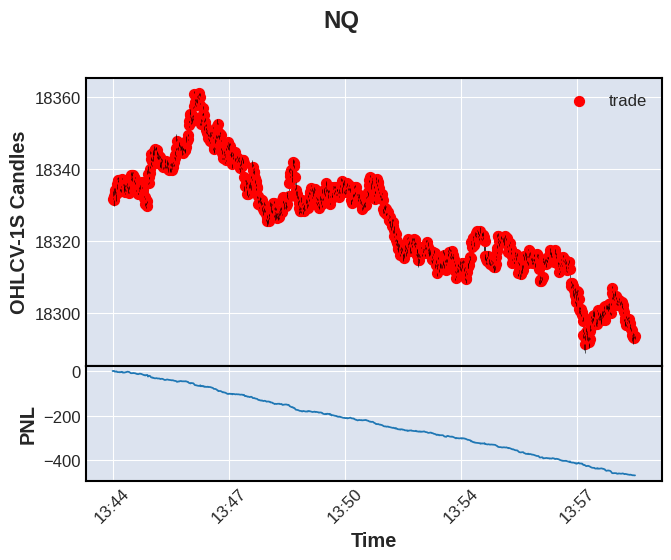

In [27]:

def chart(nq_ohlc_df: pd.DataFrame, trades_df: any) -> None:
    if trades_df.empty:
        print("No trades to plot.")
        return    
    trade_plot = mpf.make_addplot(trades_df['price'], 
                                  type='scatter', 
                                  markersize=200, 
                                  marker='.', 
                                  color='r', 
                                  label="trade")
    # trade_plot = mpf.make_addplot(trades_df['price'], 
    #                               type='scatter', 
    #                               markersize=200, 
    #                               marker='.', 
    #                               color='r', 
    #                               label="trade")
    pnl = mpf.make_addplot(trades_df['pnl'],panel=1,type='line',ylabel='PNL')

    mpf.plot(
        nq_ohlc_df,
        type="candle",
        # volume=True,
        title="NQ",
        ylabel="OHLCV-1S Candles",
        ylabel_lower="Volume",
        xlabel="Time",
        addplot=[trade_plot, pnl]
    )

trades_df['pnl'] = trades_df['pnl'].fillna(method='ffill')
# Call chart function
chart(nq_ohlc_df, trades_df)
